## Intro

This example project concerns itself with
- predicting the value of a car based on information like mileage, the make and model of the car.
- quantifying depreciation of a car w.r.t the mileage it clocks up


## Mount Google Drive to access car listing data

In [3]:
#@title
## Mounting google drive as a virtual `drive` to gain access to data 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

path = '/gdrive/My Drive/Python/Tutorials/webscrapping'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


## Import analysis libraries and set plot aesthetics

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance
from statsmodels.api import qqplot

In [0]:
## Controlling plot aesthetics
plt.style.use('fivethirtyeight')
plt.rcParams['grid.linestyle'] = '-.'
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['patch.facecolor'] = 'white';

## Import data and check columns and rows

In [0]:
dtype_dict = {'Year':int, 'Make':str, 'Model':str, 'Detailed_model':str, 'Price':float, 'Mileage':float, 'Website': str}
car_listings = pd.read_csv(path + '/car_listings.csv', dtype=dtype_dict)

In [7]:
car_listings.head()

,Year,Make,Model,Detailed_model,Price,Mileage,Website
0,2018,Toyota,Camry,XLE,17995.0,26882.0,CG
1,2005,Toyota,Camry,XLE,4495.0,107990.0,CG
2,2012,Toyota,Camry,SE,8995.0,81010.0,CG
3,2013,Toyota,Camry,SE,5995.0,157800.0,CG
4,2018,Toyota,Camry,LE,16999.0,15324.0,CG


In [8]:
display(car_listings.describe())
print("====")
display(car_listings.info())

,Year,Price,Mileage
count,6951.000000,6876.000000,6951.000000
mean,2015.138685,13829.886707,52450.505970
std,3.149610,5496.497766,40586.502014
min,1998.000000,1788.000000,5.000000
25%,2014.000000,9995.000000,23710.500000
50%,2016.000000,13999.000000,38818.000000
75%,2017.000000,17922.000000,77001.000000
max,2019.000000,33500.000000,293258.000000


====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6951 entries, 0 to 6950
Data columns (total 7 columns):
Year              6951 non-null int64
Make              6951 non-null object
Model             6951 non-null object
Detailed_model    6789 non-null object
Price             6876 non-null float64
Mileage           6951 non-null float64
Website           6951 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 380.2+ KB


None

$75$ rows in the car_listing dataframe miss 'Price' info. We therefore need to remove them because listing price is crucial for the following analysis.

In [0]:
car_listings = car_listings[car_listings.Price.notnull()]

In [10]:
car_listings.groupby(by='Make').agg({'Price':['mean', 'count'], 'Mileage':'mean'})

Price             Mileage
                    mean count          mean
Make                                        
Chevrolet   13105.290672   461  47087.793926
Ford        13464.998968   969  51970.287926
Honda       18073.285034  1470  35781.780272
Hyundai     12441.247606   731  48418.470588
Nissan      10416.959726  1167  73716.958869
Toyota      13727.585714  1610  55575.767702
Volkswagen  13001.905983   468  52694.399573

## Removing duplicate values

Car listing websites may allow the same car to be posted several times.
This may negatively affect our analysis so we need to remove duplicate 
entries in the car listing data frame

In [0]:
car_listings = car_listings.drop(car_listings[car_listings.duplicated()].index)

In [12]:
# After removing duplications
car_listings.groupby(by='Make').agg({'Price':['mean', 'count'], 'Mileage':'mean'})

Price             Mileage
                    mean count          mean
Make                                        
Chevrolet   14968.050725   138  43805.405797
Ford        16067.329439   428  39592.558411
Honda       17576.024390   492  44949.550813
Hyundai     14092.875000   208  45860.850962
Nissan      14269.413265   392  48258.359694
Toyota      16163.507491   534  44996.722846
Volkswagen  14658.027473   182  44786.362637

## Correlation matrix for Mileage, Year and Price

In [13]:
car_listings.corr()

,Year,Price,Mileage
Year,1.000000,0.789892,-0.769119
Price,0.789892,1.000000,-0.804612
Mileage,-0.769119,-0.804612,1.000000


## Box plot to visualize distribution of data accross models

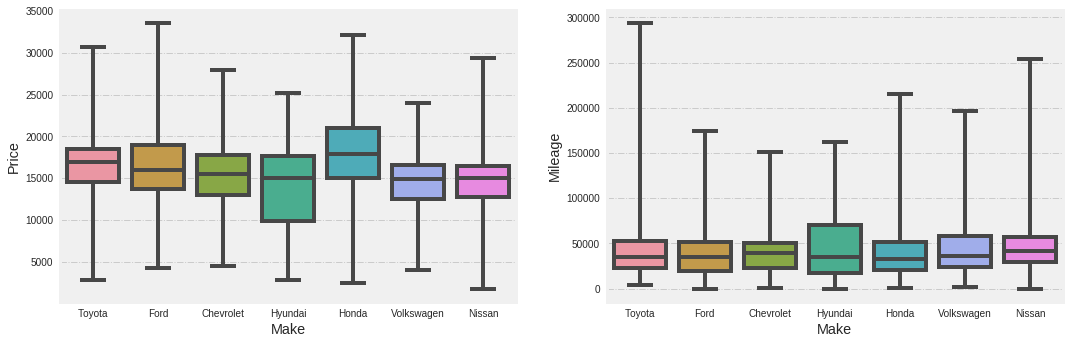

In [14]:
fig = plt.figure(figsize=(16,5))
ax1, ax2 = fig.subplots(1, 2)
sns.boxplot(x="Make", y="Price", data=car_listings, whis="range", ax=ax1)
sns.boxplot(x="Make", y="Mileage", data=car_listings, whis="range", ax=ax2)


In [0]:

def plot(make, df=None, plt_type='scatter'):
  if df is None:
    print("data frame none")
    df = car_listings
  fig = plt.figure(figsize=(12,5))
  axes = fig.subplots(1,2)

  labels = {
      'Mileage':['0', '25K','50K', '100K', '125K', '150K', '200K'], 
      'Year':range(1995, 2021, 5),
      }
  
  for index, column in enumerate(['Mileage', 'Year']):
    axes[index].set_xticklabels(labels[column])
    if plt_type == 'scatter':
      sns.scatterplot(df[(df.Make == make)][column],df[df.Make == make]['Price'], ax=axes[index])
    elif plt_type == 'kde':
      sns.kdeplot(df[column], ax=axes[index],shade=True)
    axes[index].set_title(make)

In [0]:
def transform(series, transformation):
  '''Transform a series into another series
  '''
  if callable(transformation):
    return transformation(series)
  elif transformation == 'center':
    return series - np.mean(series)
  elif transformation == 'standardize':
    return (series - np.mean(series))/np.std(series)

def train_linear_regression(train):
  ''' Takes in the training set 'train' and performs LASSO
  in two steps. First LASSO Cross Validation is used to 
  select the alpha regularization hyper-parameter that optimizes 
  between OLS and regularization costs. Second, this parameter is 
  used to train a Lasso model'''
  lasso_cv = LassoCV( cv=5, random_state=0)
  lasso_cv.fit(train.drop('Price', axis=1), train.Price)

  lasso = Lasso(normalize=True,random_state=0,alpha=lasso_cv.alpha_)
  lasso.fit(train.drop('Price', axis=1), train.Price)
  return lasso

def train_test_plot(dataframe, columns):
  train, test = train_test_split(dataframe[columns])
  model = train_linear_regression(train)

  # Price should be the last in the 'columns' list!
  predicted = dataframe[columns[:-1]].dot(model.coef_) + model.intercept_
  r2_score = model.score(test[columns[:-1]], test['Price'])

  # pred_error_visualizer = PredictionError(model)

  # pred_error_visualizer.fit(train[columns[:-1]], train['Price'])  
  # pred_error_visualizer.score(test[columns[:-1]], test['Price'])  
  # pred_error_visualizer.poof()
  # print(' ')

  residual_visualizer = ResidualsPlot(model)

  residual_visualizer.fit(train[columns[:-1]], train['Price'])  
  residual_visualizer.score(test[columns[:-1]], test['Price'])  
  residual_visualizer.poof() 
  return model

### 1. Analyzing the Toyota Camry data

In [77]:
toyota = car_listings[car_listings.Make == 'Toyota'].copy()
toyota.sort_values(by='Mileage')
toyota.reset_index(inplace=True,drop=True)
toyota.describe()

,Year,Price,Mileage
count,534.000000,534.000000,534.000000
mean,2015.505618,16163.507491,44996.722846
std,3.172786,4605.462500,35494.652744
min,1998.000000,2845.000000,3418.000000
25%,2014.000000,14562.500000,22512.000000
50%,2016.000000,16967.500000,34708.000000
75%,2018.000000,18518.750000,52946.750000
max,2019.000000,30670.000000,293258.000000


data frame none


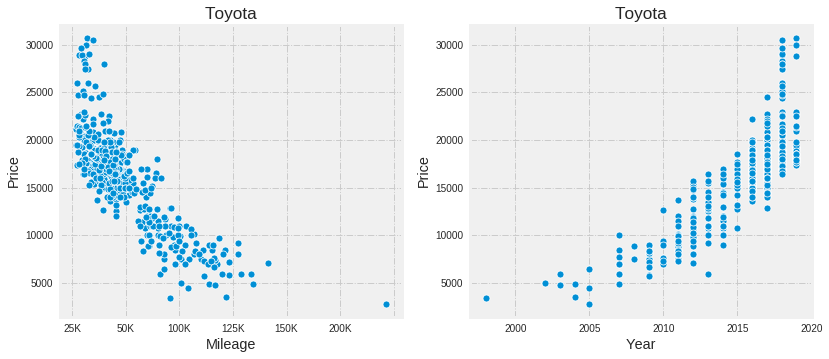

In [59]:
plot('Toyota')

In [60]:
toyota.corr()

,Year,Price,Mileage
Year,1.000000,0.831563,-0.773044
Price,0.831563,1.000000,-0.815916
Mileage,-0.773044,-0.815916,1.000000


In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_test = toyota[['Mileage', 'Year']].copy()
vif_test['Intercept'] = np.ones(vif_test.shape[0])

pd.Series([variance_inflation_factor(vif_test.values, i) for i in range(vif_test.shape[1])], index=vif_test.columns)

Mileage      2.485072e+00
Year         2.485072e+00
Intercept    1.007812e+06
dtype: float64

### 1.1 Check botton and top ends of the Price and Mileage columns

In [62]:
# Price
display(toyota.sort_values(by='Price').head())
display(toyota.sort_values(by='Price').tail())

,Year,Make,Model,Detailed_model,Price,Mileage,Website
6763,2005,Toyota,Camry,LE I4,2845.0,293258.0,TC
6720,1998,Toyota,Camry,LE I4,3387.0,90940.0,TC
14,2004,Toyota,Camry,XLE V6,3495.0,143595.0,CG
1,2005,Toyota,Camry,XLE,4495.0,107990.0,CG
6791,2003,Toyota,Camry,XLE I4,4800.0,133325.0,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
6758,2018,Toyota,Camry,Hybrid,29000.0,15329.0,TC
6761,2018,Toyota,Camry,XSE V6,29680.0,8330.0,TC
6760,2019,Toyota,Camry,XSE V6,29980.0,13096.0,TC
6762,2018,Toyota,Camry,XSE V6,30520.0,19116.0,TC
6481,2019,Toyota,Camry,XSE V6,30670.0,13655.0,TC


In [63]:
# Mileage
display(toyota.sort_values(by='Mileage').head())
display(toyota.sort_values(by='Mileage').tail())
display([toyota.Mileage.mean() - (3*toyota.Mileage.std()), toyota.Mileage.mean() + (3*toyota.Mileage.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
6476,2017,Toyota,Camry,LE I4,19490.0,3418.0,TC
6456,2018,Toyota,Camry,LE I4,21130.0,3936.0,TC
6743,2017,Toyota,Camry,LE I4,19495.0,4268.0,TC
6777,2016,Toyota,Camry,LE I4,17390.0,4616.0,TC
6467,2017,Toyota,Camry,XLE I4,21491.0,4772.0,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
3,2013,Toyota,Camry,SE,5995.0,157800.0,CG
6755,2007,Toyota,Camry,LE I4,5895.0,167101.0,TC
6793,2007,Toyota,Camry,NaN,4895.0,168908.0,TC
6669,2012,Toyota,Camry,SE I4,7133.0,182627.0,TC
6763,2005,Toyota,Camry,LE I4,2845.0,293258.0,TC


[-61487.23538505401, 151480.6810779379]

We have a handful of cars that are driven more than 3 times the standard deviation of mileage. These could be problematic when trying to fit a regression model as linear regression can be affected by outliers (esp. large ones)

In [78]:
outliers = toyota[toyota.Mileage > toyota.Mileage.mean() + (3*toyota.Mileage.std())]
# These 'outliers' are not that many so we can safely drop them
print(outliers.shape)

(7, 7)


In [0]:
toyota.drop(outliers.index, inplace=True)

In [66]:
toyota.describe()

,Year,Price,Mileage
count,527.000000,527.000000,527.000000
mean,2015.580645,16294.688805,43166.736243
std,3.104738,4486.313024,31503.812653
min,1998.000000,3387.000000,3418.000000
25%,2015.000000,14699.000000,22368.500000
50%,2017.000000,16988.000000,34538.000000
75%,2018.000000,18572.000000,50500.500000
max,2019.000000,30670.000000,146780.000000


### 1.2 PDF of the Mileage and year variables

### 1.3 Exploring features
---

In [0]:
toyota['Year_ctr'] = transform(toyota.Year, 'center')
toyota['Year_std'] = transform(toyota.Year, 'standardize')
toyota['Year_SQ_std'] = transform((toyota.Year**2), 'standardize')
toyota['Mileage_std'] = transform(toyota.Mileage, 'standardize')
toyota['Mileage_SQRT_std'] = transform(transform(toyota.Mileage, np.sqrt) , 'standardize')
toyota['Mileage_log_std'] = transform(transform(toyota.Mileage, np.log2), 'standardize')

toyota['XLE_XSE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XLE|XSE', na=False)] 
toyota['Hybrid'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('Hybrid', na=False)] 

---

### 1.4 First attempt: Price as a simple linear function of Mileage

$$P_i = w_0 + w_1 M_i$$

where $P_i$ and $M_i$ are the $i^{th}$ price and standardized mileage <br/>
and $w_0$ and $w_1$ are the intercept and weight to be 'learned' by the model

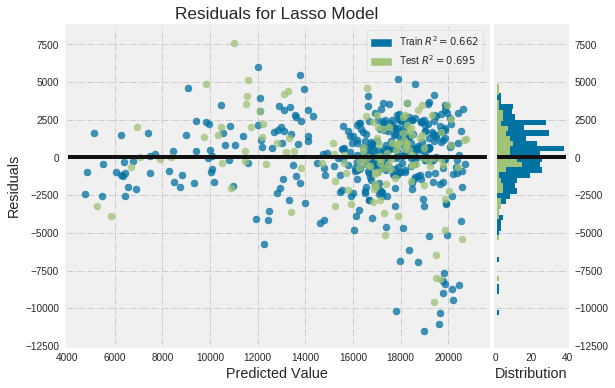

 
[-3507.13431923] 16314.480584121993


In [27]:
simple_linear_model = train_test_plot(toyota, ['Mileage_std', 'Price'])
print(" ")
print(simple_linear_model.coef_, simple_linear_model.intercept_)

The coefficient tells us that for every standardad deviation increase <br/>
in mileage (i.e. for every 31K mileage) the price of the car drops by 3600 dollars. 

However the residuals show strong ***heteroscedasticity*** that needs fixing. <br/>
Note that for a simple regression, our model has a high $R^2$ score but before <br/> considering model performance seriously, let us first try to fix the heteroscedasticity

Our model systematically under-predicted the price of the expensive cars.<br/>
As shown in the cell below, these cars also happen to have the least <br/>
mileage.

A linear relationship between mileage and price performs relatively well<br/>
for cars that are driven long enough. However, for those cars that reside <br/>
on the boundaries of being "New" and "Used" (i.e. cars whose mileage is <br/>
within the first few thousands), the depreciation with respect to mileage <br/>is more stronger than the one suggested by the linear model.

### 1.5 Trying to fix heteroscedasticity by setting lower bound on mileage

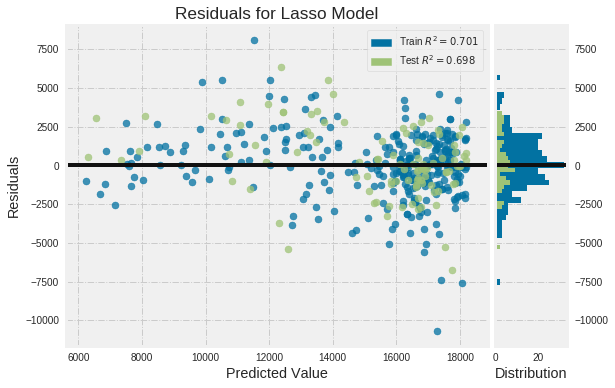

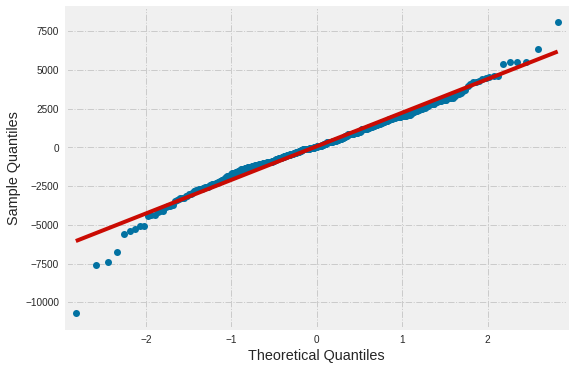

In [28]:
model = train_test_plot(toyota[(toyota.Mileage > 20000)], ['Mileage_std', 'Price'])
residuals = model.predict(toyota[(toyota.Mileage > 20000)][['Mileage_std']])  -  toyota[(toyota.Mileage > 20000)]['Price']
qqplot(residuals, line='r');

### Checking if the luxury versions are unevely distributed accross the years

If luxury versions are recent introduction they will also have less mileage.<br/>
This could impair the performance of our model if the luxury version are <br/>
distributed in a unbalanced manner accross the independent variable (i.e. mileage) <br/>

In [29]:
lux = toyota.Detailed_model.str.contains('XSE|XLE|Hybrid|V6', na=False)
display(toyota[lux].Year.describe())
print('\n')
display(toyota.drop(toyota[lux].index).Year.describe())

count     136.000000
mean     2014.889706
std         3.281086
min      2003.000000
25%      2013.000000
50%      2016.000000
75%      2017.000000
max      2019.000000
Name: Year, dtype: float64

count     391.000000
mean     2015.820972
std         3.008308
min      1998.000000
25%      2015.000000
50%      2017.000000
75%      2018.000000
max      2019.000000
Name: Year, dtype: float64

No siginificant imbalance detected in the distribution of the luxury versions.

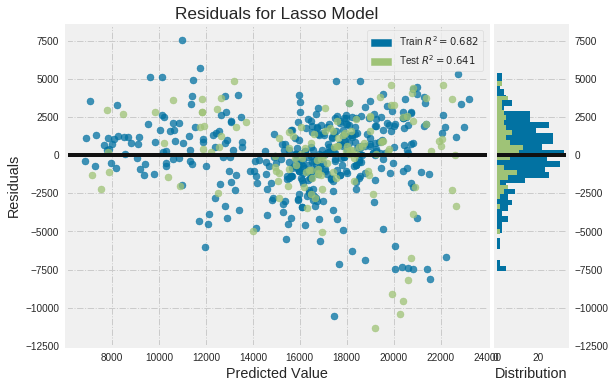

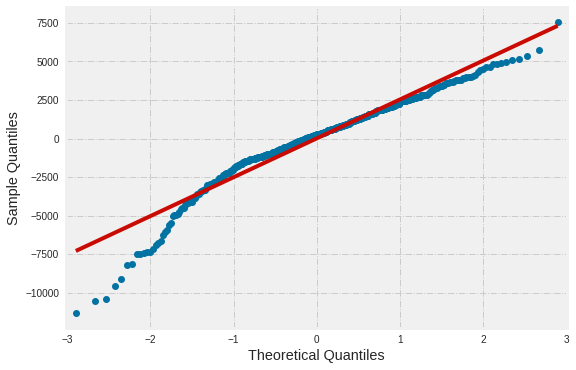

In [30]:
model = train_test_plot(toyota, ['Mileage_SQRT_std', 'Price'])
residuals = model.predict(toyota[['Mileage_SQRT_std']])  -  toyota['Price']
qqplot(residuals, line='r');

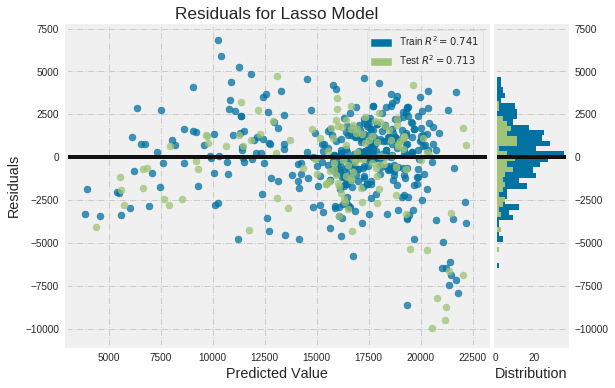

[-3587.80042746  2117.27392668  1921.01987799] 15691.409954911644


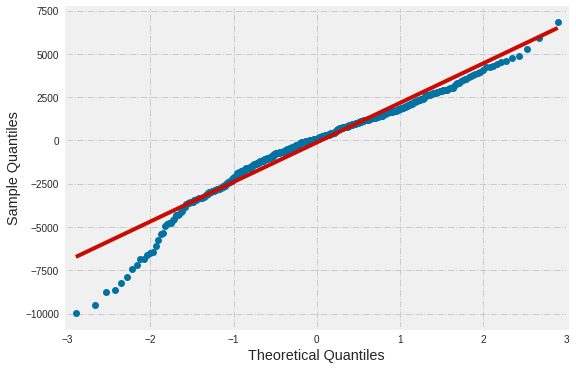

In [129]:
model = train_test_plot(toyota, ['Mileage_std', 'XLE_XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[['Mileage_std', 'XLE_XSE', 'Hybrid']])  -  toyota['Price']
qqplot(residuals, line='r')
print(model.coef_, model.intercept_)

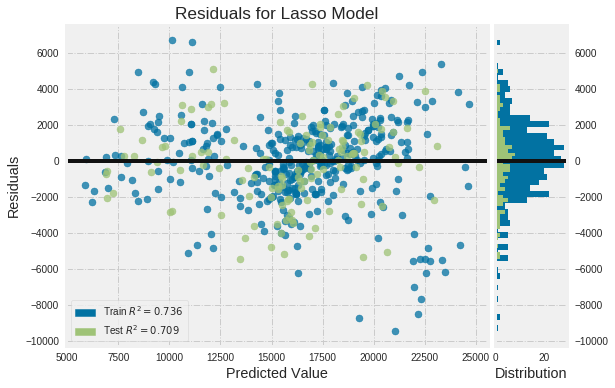

[-3670.56646795  2368.81279144  2556.36807535] 15687.02379758825


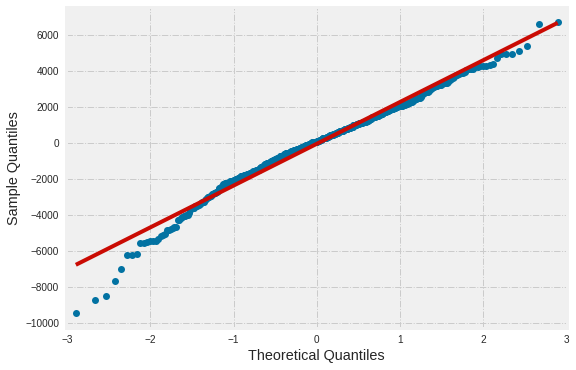

In [130]:
model = train_test_plot(toyota, ['Mileage_SQRT_std', 'XLE_XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[['Mileage_SQRT_std', 'XLE_XSE', 'Hybrid']])  -  toyota['Price']
qqplot(residuals, line='r')
print(model.coef_, model.intercept_)

In [33]:
toyota.Mileage.describe()

count       527.000000
mean      43166.736243
std       31503.812653
min        3418.000000
25%       22368.500000
50%       34538.000000
75%       50500.500000
max      146780.000000
Name: Mileage, dtype: float64

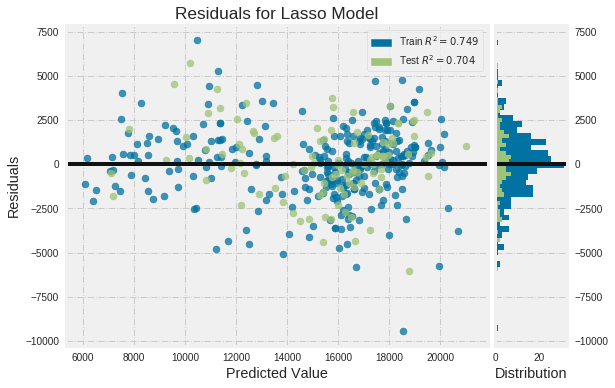

array([-3749.84466322,  1201.86396597,  2564.9101776 ])

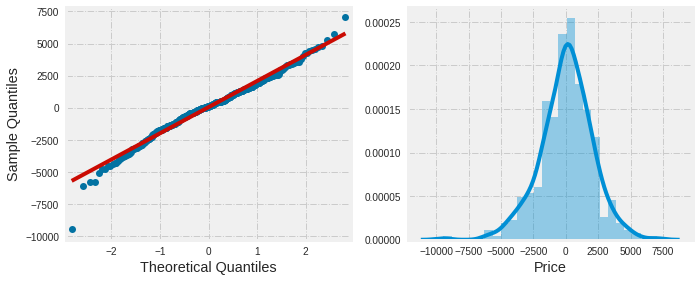

In [137]:
model = train_test_plot(toyota[toyota.Mileage > 20000], ['Mileage_SQRT_std', 'XLE_XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[toyota.Mileage > 20000][['Mileage_SQRT_std', 'XLE_XSE', 'Hybrid']])  -  toyota[toyota.Mileage > 20000]['Price']
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
model.coef_

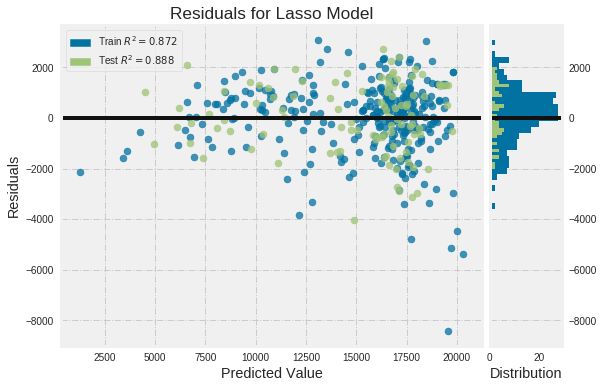

array([-1991.88107535,  2042.41224885,  1503.98167167,  2194.55303662])

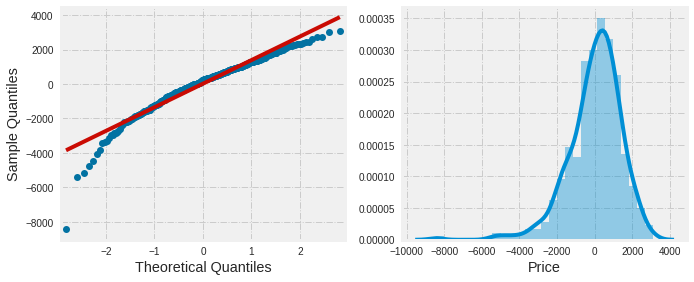

In [140]:
model = train_test_plot(toyota[toyota.Mileage > 20000], ['Mileage_SQRT_std', 'Year_SQ_std','XLE_XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[toyota.Mileage > 20000][['Mileage_SQRT_std', 'Year_SQ_std','XLE_XSE', 'Hybrid']])  -  toyota[toyota.Mileage > 20000]['Price']
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
model.coef_

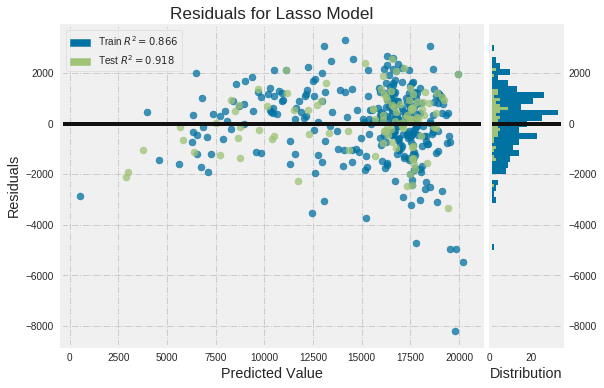

array([-1588.26853217,  2232.86206367,  1789.0754585 ,  2020.3699996 ])

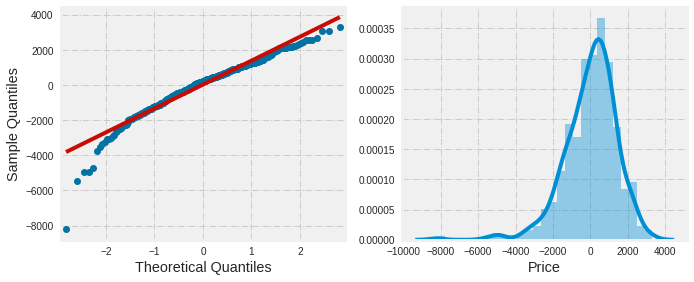

In [127]:
model = train_test_plot(toyota[toyota.Mileage > 20000], ['Mileage_std', 'Year_std','XLE_XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[toyota.Mileage > 20000][['Mileage_std', 'Year_std','XLE_XSE', 'Hybrid']])  -  toyota[toyota.Mileage > 20000]['Price']
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
model.coef_

In [124]:
np.mean(residuals)/np.std(residuals, ddof=residuals.shape[0] -1)

0.0007680479289349364

In [107]:
print(np.std(residuals, ddof=1))
print(1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1)))

1382.1204700731448
2721.794236537462


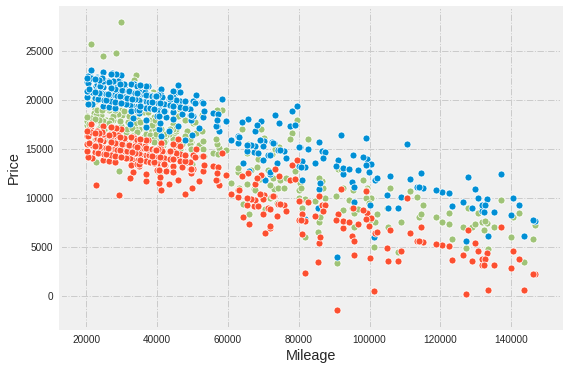

In [142]:
fig, ax = plt.subplots()
interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))
predictions = model.predict(toyota[toyota.Mileage > 20000][['Mileage_std', 'Year_SQ_std','XLE_XSE', 'Hybrid']])
upper, lower = predictions + interval, predictions - interval
sns.scatterplot(x=toyota[toyota.Mileage > 20000].Mileage, y=toyota[toyota.Mileage > 20000].Price, ax=ax,color='g')
sns.scatterplot(x=toyota[toyota.Mileage > 20000].Mileage, y=upper, ax=ax)
sns.scatterplot(x=toyota[toyota.Mileage > 20000].Mileage, y=lower, ax=ax)

In [143]:
pred = model.predict([[(50000 - np.mean(toyota.Mileage))/np.std(toyota.Mileage), (2016 - np.mean(toyota.Year))/np.std(toyota.Year), 1, 0]])
print(pred)
print(pred - interval, pred + interval)
print(pred - interval/np.sqrt(toyota.shape[0]), pred + interval/np.sqrt(toyota.shape[0]))

[17165.50852416]
[14423.34701705] [19907.67003127]
[17046.05809276] [17284.95895556]


In [37]:
toyota[(toyota.Price > 25000) & (toyota.Mileage > 15000)][['Year', 'Mileage', 'Price', 'Detailed_model']]

,Year,Mileage,Price,Detailed_model
6758,2018,15329.0,29000.0,Hybrid
6759,2018,29708.0,27998.0,XSE V6
6762,2018,19116.0,30520.0,XSE V6
6800,2018,21355.0,25700.0,XSE I4


In [108]:
toyota.columns

Index(['Year', 'Make', 'Model', 'Detailed_model', 'Price', 'Mileage',
       'Website', 'Year_ctr', 'Year_std', 'Year_SQ_std', 'Mileage_std',
       'Mileage_SQRT_std', 'Mileage_log_std', 'XLE_XSE', 'Hybrid'],
      dtype='object')

In [38]:
toyota[toyota.Detailed_model.str.contains('V6', na=False)].groupby(by='Detailed_model').agg({'Year': 'count'})

,Year
Detailed_model,
2014 SE V6,1
2014 XLE V6,1
LE V6,4
SE V6,7
XLE V6,20
XSE V6,11


In [39]:
print(toyota[toyota.Detailed_model.str.contains('XSE|XLE', na=False)].shape)
print(toyota[toyota.Detailed_model.str.contains('XSE I4|XLE I4', na=False)].shape)
print(toyota[toyota.Detailed_model.str.contains('XSE V6|XLE V6', na=False)].shape)
toyota[toyota.Detailed_model.str.contains('XSE|XLE', na=False)].groupby(by='Detailed_model').agg({'Year': 'count'})

(100, 15)
(66, 15)
(32, 15)


,Year
Detailed_model,
2014 XLE I4,2
2014 XLE V6,1
XLE,2
XLE I4,44
XLE V6,20
XSE I4,20
XSE V6,11


In [40]:
toyota.groupby(by='Detailed_model').agg({'Year': 'count'})

,Year
Detailed_model,
2014 Hybrid,2
2014 L I4,1
2014 LE I4,10
2014 SE I4,4
2014 SE Sport I4,1
2014 SE V6,1
2014 XLE I4,2
2014 XLE V6,1
Hybrid,22


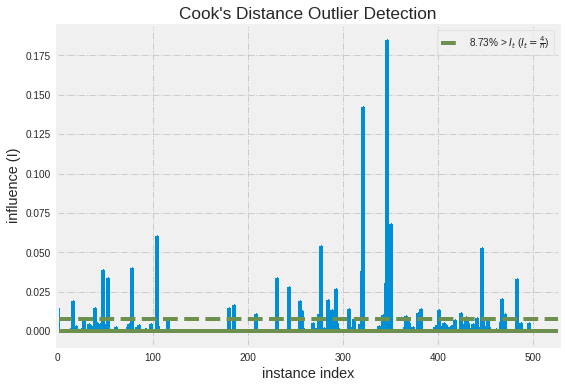

In [81]:
X, y = toyota[['Mileage_std', 'Year_std','XLE_XSE', 'Hybrid']], toyota.Price

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.poof()

In [0]:
visualizer.influence_threshold_
visualizer.p_values_;

In [83]:
toyota.loc[330:350,['Detailed_model', 'Price']]

,Detailed_model,Price
330,LE I4,18000.0
331,LE I4,15017.0
332,LE I4,16500.0
333,SE I4,17954.0
334,LE I4,14995.0
335,LE I4,16995.0
336,LE I4,19495.0
337,SE I4,16500.0
338,LE I4,16991.0
339,SE I4,16999.0


In [0]:

def performance(make, rep=10, mileage_poly=False):
  result = {
      'mileage_poly': mileage_poly,
      'train':[],
      'test':[],
      'score':[]
  }

  for _ in range(rep):
    train, test = get_df(make, mileage_poly)
    regression_model = train_cv(train)
    result['test'].append(int(rmse(regression_model, test)))
    result['train'].append(int(rmse(regression_model, train)))
    result['score'].append(regression_model.score(test.drop('Price', axis=1), test.Price))
  train_mean, test_mean = np.mean(result['train']), np.mean(result['test'])
  train_std, test_std = np.std(result['train']), np.std(result['test'])
  train_conf =  [train_mean - 1.96 * train_std/train.shape[0], train_mean + 1.96 * train_std/train.shape[0]]
  test_conf = [test_mean - 1.96 * test_std/test.shape[0], test_mean + 1.96 * test_std/test.shape[0]]
  stats = {
      'mileage_poly': mileage_poly,
      'mean_rmse': {'train': np.mean(result['train']), 'test':np.mean(result['test'])},
      'std_rmse': {'train': np.std(result['train']), 'test':np.std(result['test'])},
      '95_conf_rmse':{'train': train_conf, 'test':test_conf},
      'score': {'mean': np.mean(result['score']), 'std': np.std(result['score'])}
  }
  return stats

In [0]:

def coin_flip(n):
  rand = np.random.random()
  tosses = np.random.choice([0,1],size=n,p=[1-rand,rand])
  # print(rand)
  return tosses

flips = coin_flip(100)
flips

In [0]:
np.sum(flips) / len(flips)

In [0]:
from scipy.stats import norm

2 * norm.cdf(-2.6)

In [0]:
norm.cdf(-1.21)

In [0]:
## Import the packages
import numpy as np
from scipy import stats


## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt(var_a + var_b)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s/np.sqrt(N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

In [0]:
stats.ttest_rel??